In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
from glob import glob
import os

from scipy import ndimage
from sklearn import neighbors

In [2]:
struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)
theta = np.linspace(-np.pi, np.pi, 50)

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
csrc = '../data/'
dst = '../results/'

sample = 'D2'

radius = 30
maxdwall = 6
minneighs = 5
minprob = 74

In [6]:
wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, struc1)
nuclei = tf.imread(nsrc + sample + '_EDT.tif') < 2
wall[nuclei] = False

wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
wc = wcoords[:, ~np.all(wcoords%50, axis=0)]

In [4]:
filename = csrc + sample + '_data/32771-slide1_' + sample + '_results.txt'
data = pd.read_csv(filename, header=None, sep='\t').drop(columns=[4])
data.columns = ['X', 'Y', 'Z', 'T']

transcriptomes, invidx, tsize = np.unique(data.iloc[:,-1], return_index = False, return_inverse=True, return_counts=True) 
print(len(transcriptomes), 'transcriptomes')

targsort = np.argsort(tsize)[::-1]
for i in range(20):
    print(i+1, targsort[i], transcriptomes[targsort[i]], tsize[targsort[i]] , sep='\t')
print(data.shape)
data.iloc[:,:3].describe().drop(index='count').T.astype(dict(zip(['min','25%','50%','75%','max'], [int for i in range(5)])))

97 transcriptomes
1	2	BAC47034	1820064
2	85	GLYMA_17G195900	796880
3	26	GLYMA_05G092200	776841
4	7	BAC52602	121477
5	62	GLYMA_12G027400	53706
6	77	GLYMA_16G039800	37913
7	0	BAC45727	32613
8	57	GLYMA_11G008000	22998
9	28	GLYMA_05G216000	19464
10	84	GLYMA_17G185800	17018
11	25	GLYMA_05G023700	15123
12	74	GLYMA_15G210100	14368
13	16	GLYMA_02G003700	9003
14	27	GLYMA_05G203100	6415
15	30	GLYMA_06G065000	5477
16	47	GLYMA_09G127000	5108
17	31	GLYMA_06G090100	4916
18	22	GLYMA_04G063800	4625
19	10	CYP93A1	3929
20	24	GLYMA_04G227200	3687
(3830384, 4)


,mean,std,min,25%,50%,75%,max
X,9018.809175,3467.651045,3,6087,9157,11895,17146
Y,8152.751641,2937.713570,2,5718,8003,10380,17133
Z,28.216312,7.161211,1,23,28,33,61


In [7]:
tidx = 26

tcoords = data.loc[invidx == tidx , ['X', 'Y', 'Z'] ].values.T
nmask = ~nuclei[ tcoords[1], tcoords[0] ]
coords = tcoords[:2, nmask]
tlabs = label[coords[1], coords[0] ].astype(int)
tpercell, _ = np.histogram(tlabs, np.arange(cellnum+2))
print(transcriptomes[tidx], np.sum(nmask), len(nmask) - np.sum(nmask), np.round(100*np.sum(nmask)/len(nmask),1), sep='\t')

GLYMA_05G092200	764852	11989	98.5


# Deal with transcripts on the edge

In [6]:
def correct_boundary_transcripts(R = 25):
    for i in np.nonzero(tlabs == 0)[0]:
        x,y = coords[:,i]
        ss = np.s_[y - R : y + R, x - R : x + R]
        cells = np.unique(label[ss])[1:]
        newlab = cells[np.argmax(tpercell[cells])]
        com = np.flip(np.mean(np.asarray(np.nonzero(label[ss] == newlab)), axis=1))
        com[0] += x - R
        com[1] += y - R
        dv = com - coords[:,i]
        dv = dv/np.linalg.norm(dv)
        delta = 1
        x,y = (coords[:,i] + delta*dv).astype(int)
        
        while(label[y,x] != newlab) and (delta < 50):
            delta += 1
            x,y = (coords[:,i] + delta*dv).astype(int)
        if delta < 50:
            coords[:,i] = [x,y]
            tlabs[i] = newlab
        else:
            print('Review index', i)

    return 0

In [14]:
foo = np.sum(tlabs == 0)
print('Initially, there are\t',foo,'\ttranscripts on the walls',sep='')
print(np.nonzero(tlabs == 0)[0][:15])
if foo > 0:
    correct_boundary_transcripts(R=5)
    foo = np.sum(tlabs == 0)
    print('Now there are\t',foo,'\ttranscripts on the walls',sep='')

Initially, there are	532	transcripts on the walls
[   5  173  191  223  355  717  723  824  959 1023 1044 1111 1377 1440
 1589]
Now there are	0	transcripts on the walls


In [15]:
i = 5
R = 5
x,y = coords[:,i]
print(x,y)
ss = np.s_[y - R : y + R, x - R : x + R]
cells = np.unique(label[ss])[1:]
print(cells, tpercell[cells], sep='\n')
newlab = cells[np.argmax(tpercell[cells])]
com = np.flip(np.mean(np.asarray(np.nonzero(label[ss] == newlab)), axis=1))
com[0] += x - R
com[1] += y - R
dv = com - coords[:,i]
dv = dv/np.linalg.norm(dv)
delta = 1
x,y = (coords[:,i] + delta*dv).astype(int)

while(label[y,x] != newlab) and (delta < 50):
    delta += 1
    x,y = (coords[:,i] + delta*dv).astype(int)
print(x,y,delta)

8529 1734
[ 2 23]
[15  3]
8528 1733 1


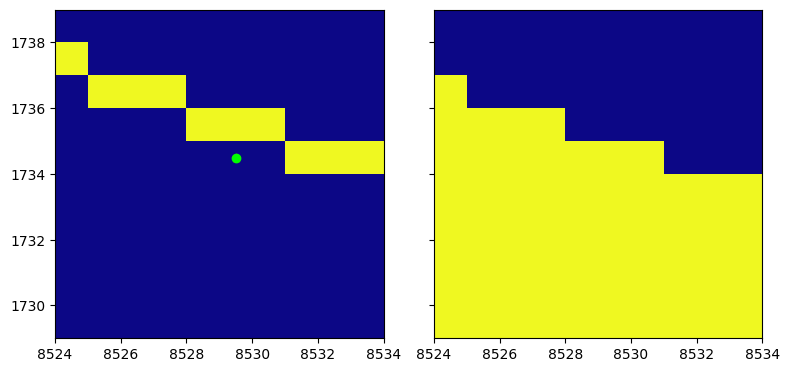

In [17]:
R = 5
x,y = coords[:,i]
ss = np.s_[y - R : y + R, x - R : x + R]

extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)

fig, ax = plt.subplots(1,2,figsize=(8,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(wall[ss], cmap='plasma_r', origin='lower', extent=extent, vmin=0)
ax[0].scatter(coords[0]+.5, coords[1]+.5, c='r', marker='*', zorder=3, alpha=1);
ax[0].scatter([x+.5], [y+.5], c='lime', marker='o', zorder=4, alpha=1);

ax[1].imshow(label[ss]==newlab, cmap='plasma', origin='lower', extent=extent, vmin=0)

for j in range(len(ax)):
    ax[j].set_aspect('equal')
    ax[j].set_xlim(extent[0],extent[1])
    ax[j].set_ylim(extent[2],extent[3])

fig.tight_layout();

# Deal with misplaced transcripts

In [18]:
def transcript_shift(i, ndist, nidxs, cat, cdtlabs, cdtmask, cdtcoords, edtmask, edtvals):
    mask = cdtlabs[nidxs[i]] == cat[i,1]
    nearest = np.average(cdtcoords[:,nidxs[i][mask]], axis=1, weights = radius - ndist[i][mask])
    dv = nearest - cdtcoords[:,edtvals[i]]
    dv = dv/np.linalg.norm(dv)
    x,y = cdtcoords[:,edtvals[i]]
    
    delta = 1
    x,y = (cdtcoords[:,edtvals[i]] + delta*dv).astype(int)
    while(label[y,x] != cat[i,1]) and (delta < radius):
        delta += 1
        x,y = (cdtcoords[:,edtvals[i]] + delta*dv).astype(int)
    if delta < radius:
        return [ [x,y], cat[i,1], True ]
    else:
        nearest = cdtcoords[:,nidxs[i][mask][0]]
        dv = nearest - cdtcoords[:,edtvals[i]]
        dv = dv/np.linalg.norm(dv)
        x,y = cdtcoords[:,edtvals[i]]
        
        delta = 1
        x,y = (cdtcoords[:,edtvals[i]] + delta*dv).astype(int)
        while(label[y,x] != cat[i,1]) and (delta < radius):
            delta += 1
            x,y = (cdtcoords[:,edtvals[i]] + delta*dv).astype(int)
        if delta < radius:
            return [ [x,y], cat[i,1], True ]
        else:
            return [ [x,y], cat[i,1], False ]

def get_neighbor_data(nidxs, indexing, minneighs, cdtlabs, cdtmask, cdtcoords, edtmask, edtvals):
    
    cat = np.zeros((len(nidxs),4), dtype=int)

    for i in indexing:
        foo, bar = np.unique(cdtlabs[nidxs[i][1:]], return_counts=True)
        if len(foo) > 1:
            cts = bar/np.sum(bar)
            
            cat[i,0] = len(foo)
            cat[i,1] = foo[np.argmax(cts)]
            cat[i,2] = cat[i,1] != cdtlabs[edtvals[i]]
            cat[i,3] = 100*np.max(cts)
    
    return cat
            
def correct_shifted_transcripts(cdtlabs, cdtmask, cdtcoords, edtmask, edtvals, maxdwall=maxdwall, minneighs=minneighs, minprob = minprob):
    neigh = neighbors.NearestNeighbors(radius=radius)
    neigh.fit(cdtcoords.T)
    
    ndist, nidxs = neigh.radius_neighbors(cdtcoords[:, edtmask].T, sort_results=True)
    nneighs = np.array(list(map(len,nidxs))) - 1
    indexing = np.nonzero(nneighs > minneighs)[0]

    cat = get_neighbor_data(nidxs, indexing, minneighs, cdtlabs, cdtmask, cdtcoords, edtmask, edtvals)
    
    indexing = np.nonzero((cat[:,2] == 1) & (cat[:,3] > 70))[0]
    for i in indexing:
        shift = transcript_shift(i, ndist, nidxs, cat, cdtlabs, cdtmask, cdtcoords, edtmask, edtvals)
        if shift[2]:
            cdtcoords[:,edtvals[i]], cdtlabs[edtvals[i]] = shift[0], shift[1]
        else:
            print('Pay attention to index\t',i)

    return len(indexing)
    #return ndist, nidxs, cat

In [20]:
foo = 100
iters = 0

cdtmask = np.nonzero(edt[coords[1], coords[0]] < radius)[0]
if np.sum(cdtmask) > 0:
    cdtlabs = tlabs[cdtmask].copy()
    cdtcoords = coords[ :,  cdtmask].copy()
    edtmask = edt[cdtcoords[1], cdtcoords[0]] < maxdwall
    if np.sum(edtmask) > 0:
        edtvals = np.nonzero(edtmask)[0]
    
        while (foo  > 0) and (iters < 20):
            iters += 1    
            foo = correct_shifted_transcripts(cdtlabs, cdtmask, cdtcoords, edtmask, edtvals, maxdwall, minneighs, minprob)
            print('Iteration: ', iters, '\tShifted\t',foo,' transcripts', sep='')
        
        shiftmask = np.any(cdtcoords != coords[ :,  cdtmask], axis=0)
        print('Shifted\t',np.sum(shiftmask),'\ttranscripts in total', sep='')
print(np.nonzero(shiftmask)[0][:20])

Iteration: 1	Shifted	49 transcripts
Iteration: 2	Shifted	4 transcripts
Iteration: 3	Shifted	2 transcripts
Iteration: 4	Shifted	0 transcripts
Shifted	55	transcripts in total


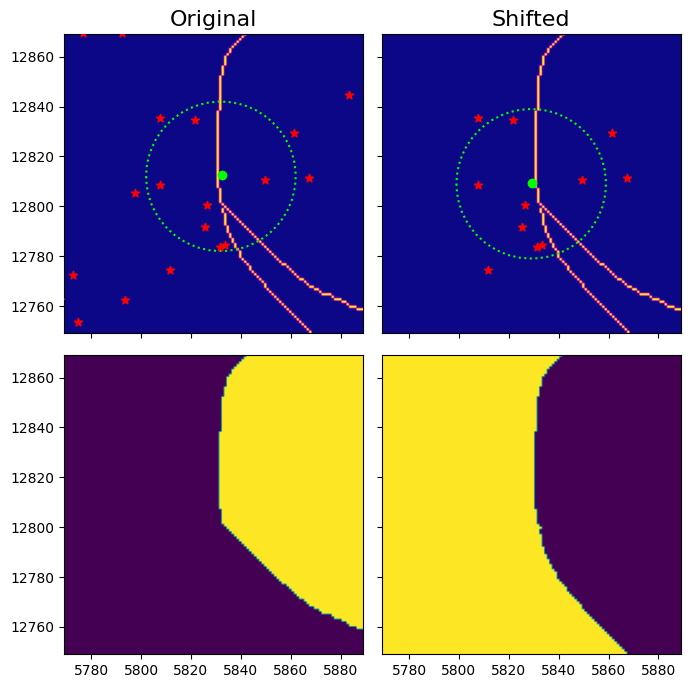

In [23]:
i = 23133

R = radius*2
x,y = cdtcoords[:,i]
ss = np.s_[y - R : y + R, x - R : x + R]
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)

fig, ax = plt.subplots(2,2,figsize=(7,7), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); fs = 16

for j in [0,1]:
    ax[j].imshow(wall[ss], cmap='plasma_r', origin='lower', extent=extent)

x0,y0 = coords[:, cdtmask][:,i]
ax[0].set_title('Original', fontsize=fs)
ax[0].scatter(coords[0]+.5, coords[1]+.5, c='r', marker='*', zorder=3, alpha=1);
ax[0].scatter([x0+.5], [y0+.5], c='lime', marker='o', zorder=4, alpha=1);
ax[0].plot(radius*np.cos(theta)+x0, radius*np.sin(theta)+y0, c='lime', ls=':')

ax[1].set_title('Shifted', fontsize=fs)
ax[1].scatter(cdtcoords[0]+0.5, cdtcoords[1]+.5, c='r', marker='*', zorder=3, alpha=1);
ax[1].scatter([x+.5], [y+.5], c='lime', marker='o', zorder=4, alpha=1);
ax[1].plot(radius*np.cos(theta)+x, radius*np.sin(theta)+y, c='lime', ls=':')


ax[2].imshow(label[ss] == tlabs[cdtmask][i], origin='lower', extent=extent);
ax[3].imshow(label[ss] == cdtlabs[i], origin='lower', extent=extent);

for j in range(len(ax)):
    ax[j].set_aspect('equal')
    ax[j].set_xlim(extent[0],extent[1])
    ax[j].set_ylim(extent[2],extent[3])

fig.tight_layout();

# Save Results

In [26]:
print(coords.shape, tlabs.shape, cdtlabs.shape, cdtcoords.shape, nmask.shape, sep='\t')

(2, 51430)	(51430,)	(32707,)	(2, 32707)	(53706,)


In [29]:
np.sum(nuclei[cdtcoords[1], cdtcoords[0]])

2

In [30]:
coords[:, cdtmask] = cdtcoords

In [34]:
coords = coords[:, ~nuclei[coords[1], coords[0]]]

(2, 51428)

In [ ]:
filename = csrc + sample + '_data/location_corrected_' + sample +'_' + transcriptomes[tidx] + '.csv'
print(filename)
df = pd.DataFrame(coords.T)
df['foo'] = transcriptomes[tidx]
df.to_csv(filename, header=False, index=False)

# Scratch code 

In [61]:
cdtmask = np.nonzero(edt[coords[1], coords[0]] < radius)[0]
cdtlabs = tlabs[cdtmask].copy()
cdtcoords = coords[ :,  cdtmask].copy()
edtmask = edt[cdtcoords[1], cdtcoords[0]] < maxdwall
edtvals = np.nonzero(edtmask)[0]

In [63]:
edtmask

array([False, False, False, False, False, False, False, False, False])

In [62]:
neigh = neighbors.NearestNeighbors(radius=radius)
neigh.fit(cdtcoords.T)

ndist, nidxs = neigh.radius_neighbors(cdtcoords[:, edtmask].T, sort_results=True)
nneighs = np.array(list(map(len,nidxs))) - 1

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by NearestNeighbors.

In [43]:
cat = np.zeros((len(nidxs),4), dtype=int)

for i in np.nonzero(nneighs > minneighs)[0]:
    foo, bar = np.unique(cdtlabs[nidxs[i][1:]], return_index=False, return_inverse=False, return_counts=True)
    if len(foo) > 1:
        cts = bar/np.sum(bar)
        
        cat[i,0] = len(foo)
        cat[i,1] = foo[np.argmax(cts)]
        cat[i,2] = cat[i,1] != cdtlabs[edtvals[i]]
        cat[i,3] = 100*np.max(cts)

```
Pay attention to index	 56801
Pay attention to index	 108781
Pay attention to index	 112090
Pay attention to index	 136631
Iteration: 1	Shifted	4649 transcripts
Pay attention to index	 1907
Pay attention to index	 4008
Pay attention to index	 44958
Pay attention to index	 56801
Pay attention to index	 66183
Pay attention to index	 94131
Pay attention to index	 108781
Pay attention to index	 114000
Pay attention to index	 124422
Pay attention to index	 134746
Pay attention to index	 136631
Pay attention to index	 136821
Pay attention to index	 139519
Pay attention to index	 163404
Pay attention to index	 164150
Pay attention to index	 169171
Iteration: 2	Shifted	1355 transcripts
Shifted	5984	transcripts in total
```

3
[ 3427 14790]
2774
[   2 2820    1   66]
[2774 2774 2774 2774 2774 2820 2820 2820 2820 2820 2774 2820 2820 2820
 2820 2820]


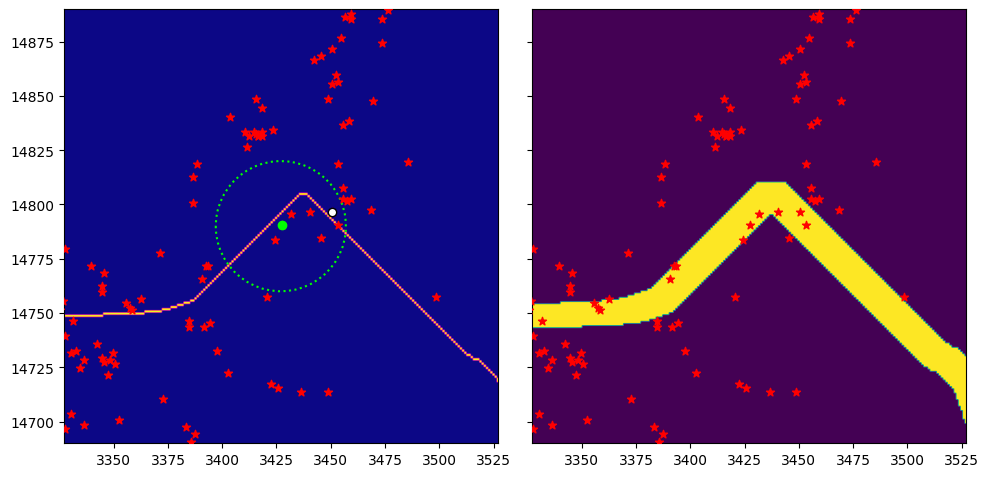

In [52]:
i = 164150

R = 100
x,y = cdtcoords[:,edtvals[i]]
mask = cdtlabs[nidxs[i]] == cat[i,1]
nearest = np.average(cdtcoords[:,nidxs[i][mask]], axis=1, weights = radius - ndist[i][mask])
nearest = cdtcoords[:,nidxs[i][mask][0]]

print(edt[y,x], cdtcoords[:,edtvals[i]], cdtlabs[edtvals[i]], cat[i], tlabs[cdtmask][nidxs[i]], sep='\n')

ss = np.s_[y - R : y + R, x - R : x + R]
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)

fig, ax = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(wall[ss], cmap='plasma_r', origin='lower', extent=extent)
ax[0].scatter(coords[0]+.5, coords[1]+.5, c='r', marker='*', zorder=3, alpha=1);
ax[0].scatter([x+.5], [y+.5], c='lime', marker='o', zorder=4, alpha=1);
ax[0].scatter(nearest[0] + .5, nearest[1] +.5, c='white', marker='o', edgecolor='k', zorder=4, alpha=1);
ax[0].plot(30*np.cos(theta)+x, 30*np.sin(theta)+y, c='lime', ls=':')

ax[1].imshow(edt[ss] < maxdwall, origin='lower', extent=extent);
ax[1].scatter(coords[0]+.5, coords[1]+.5, c='r', marker='*', zorder=3, alpha=1);


for j in range(len(ax)):
    ax[j].set_aspect('equal')
    ax[j].set_xlim(extent[0],extent[1])
    ax[j].set_ylim(extent[2],extent[3])

fig.tight_layout();

In [111]:
label[dcoords[1,31], dcoords[0,31]]

70

In [112]:
not os.path.isfile(filename)

False

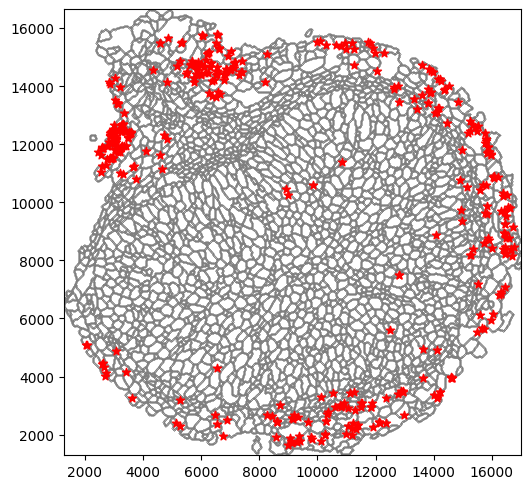

In [43]:
fig, ax = plt.subplots(1,1,figsize=(10,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].scatter(wcoords[1], wcoords[0], c='gray', marker='.', s=0.1, alpha=0.1)
ax[0].scatter(coords[0,rmask], coords[1,rmask], c='r', marker='*', zorder=3, alpha=1);

for i in range(len(ax)):
    ax[i].set_aspect('equal')
    ax[i].margins(0)

fig.tight_layout();

# Do KDE

## fastKDE method

In [8]:
if False:
    
    ss = np.s_[yneg:-ypos, xneg:-xpos]
    fpdf0, vals0 = fastKDE.pdf(*coords, axes=[xaxes, yaxes], 
                               doApproximateECF=True, ecfPrecision=2, beVerbose = True, positiveShift = True)
    print(fpdf0.shape, fpdf0.min(), fpdf0.max())
    
    def normFunc(delta):
            """Calculate how far off from normal is the shifted PDF"""
            ipos = np.nonzero((fpdf0-delta) >= 0.0)
            return 1 - np.sum(fpdf0[ipos]-delta)*pad*pad
    
    if len(np.nonzero(fpdf0 < 0)[0]) != 0:
        delta, optilog = optimize.brentq(normFunc, 0,1e-4, maxiter=200, full_output=True)
        fpdf1 = fpdf0.copy() - delta
        fpdf1[fpdf1 < 0 ] = 0
        print(np.abs(1 - np.sum(fpdf1)*pad*pad), '\n', optilog, sep='')
        pdf = fpdf1[ss].copy()/(np.sum(fpdf1[ss])*pad*pad)    
    else:
        pdf = fpdf0[ss].copy()/(np.sum(fpdf0[ss])*pad*pad)

## KDEpy FFTKDE method

In [7]:
bw = np.zeros(len(coords))
for i in range(len(bw)):
    bw[i] = ISJ(coords[ i ].reshape(-1,1))
print(bw)

coords_scaled = coords/bw.reshape(-1,1)
kde_scaled = FFTKDE(kernel='gaussian', bw=1, norm=2).fit(coords_scaled.T).evaluate(grid/bw)
isj0 = kde_scaled / np.prod(bw)
print(np.sum(isj0)*pad**2)

[46.66248378 42.5203234 ]
0.9999140668226942


In [8]:
isj = isj0[mask]/(np.sum(isj0[mask])*pad**2)
isj = isj.reshape( ( len(yaxis), len(xaxis) ), order='F')

print(isj.shape, np.sum(isj)*pad**2)

(3003, 2145) 1.000000000000001


In [53]:
kdst = '../kde/'
kdst = kdst + sample + '/'
if not os.path.isdir(kdst):
    os.mkdir(kdst)
filename = kdst + 'meta_' + sample + '_' + transcriptomes[tidx] + '.csv'
meta = [np.sum(nmask), *bw, isj.min(), isj.max()]
pd.DataFrame(meta, columns=[transcriptomes[tidx]]).T.to_csv(filename, index=True, header=False)
filename = kdst + 'kde_' + sample + '_' + transcriptomes[tidx] + '.npy'
np.save(filename, isj)

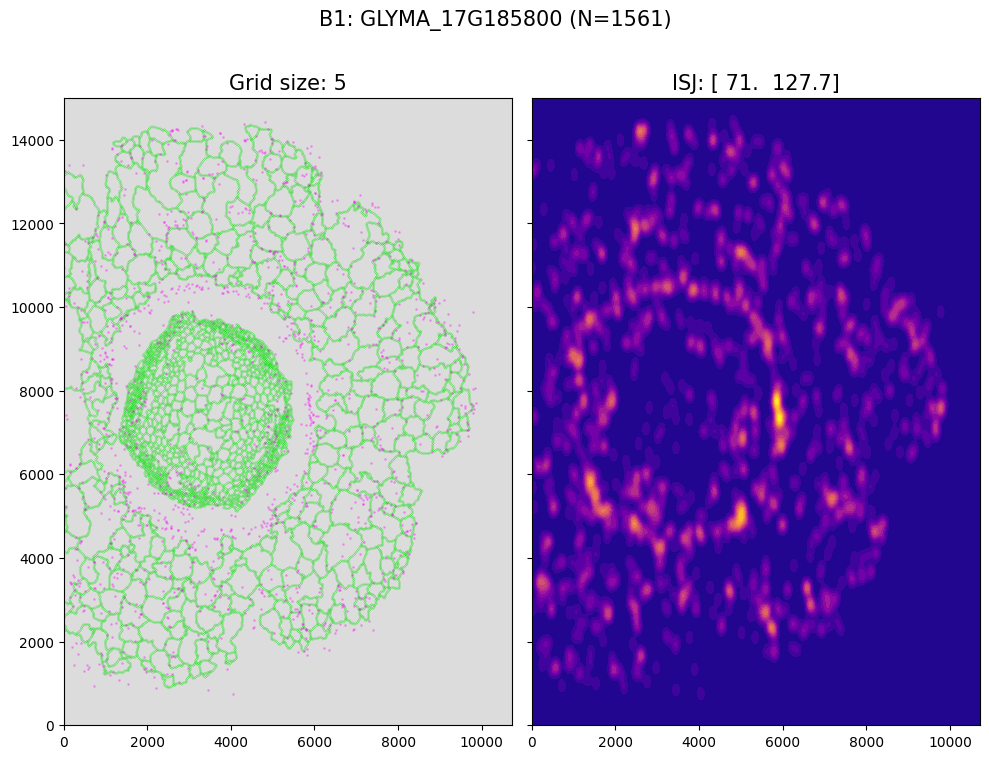

In [12]:
fs = 15
fig, ax = plt.subplots(1,2,figsize=(10,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].set_facecolor('gainsboro')
ax[0].scatter(wcoords[1], wcoords[0], c='lime', s=.01, marker='.', alpha=0.1, zorder=1);
ax[0].scatter(*coords, c='magenta', marker='o', s=1, zorder=2, alpha=0.25)

ax[1].contourf(xaxis, yaxis, isj, 16, cmap='plasma', vmin=0, zorder=1)
#ax[2].contourf(xaxis, yaxis, pdf, 16, cmap='plasma', vmin=0, zorder=1)

for i in range(len(ax)):
    ax[i].set_aspect('equal')
    ax[i].margins(0)
    ax[i].tick_params(labelsize=fs-5)

ax[0].set_title('Grid size: {}'.format(pad), fontsize=fs)
ax[1].set_title('ISJ: {}'.format(np.round(bw,1)), fontsize=fs)

fig.suptitle('{}: {} (N={})'.format(sample, transcriptomes[tidx], np.sum(nmask)), fontsize=fs);
fig.tight_layout();

#filename = kdst + '{}_-_{}_kde'.format(sample, transcriptomes[tidx])
#print(filename)
#plt.savefig(filename + '.jpg', format='jpg', dpi=150, bbox_inches='tight', pil_kwargs={'optimize':True})

# Individual cells

In [15]:
interp = interpolate.RegularGridInterpolator((yaxis, xaxis), isj, method='linear', bounds_error=True, fill_value=None)
bins = np.linspace(0, isj.max(), 256)

In [16]:
label, cellnum = ndimage.label(wall, struc1)
objss = ndimage.find_objects(label)
#hist, bins = np.histogram(label, bins=range(1,cellnum+2))
#cnuclei = np.asarray(ndimage.center_of_mass(wall, label, range(1,cellnum+1)))
print('Detected',cellnum,'cells')

Detected 1662 cells


In [34]:
csizes = np.zeros((len(objss), 4))
for i in range(len(csizes)):
    csizes[i,0] = objss[i][0].stop - objss[i][0].start
    csizes[i,1] = objss[i][1].stop - objss[i][1].start
    csizes[i,2] = csizes[i,0]/csizes[i,1]
    csizes[i,3] = csizes[i,1]/csizes[i,0]

pd.DataFrame(csizes, columns=['X', 'Y', 'X/Y', 'Y/X']).describe()

,X,Y,X/Y,Y/X
count,1662.000000,1662.000000,1662.000000,1662.000000
mean,231.392298,203.286402,1.140593,0.957939
std,469.976162,355.388183,0.364748,0.294042
min,16.000000,21.000000,0.355556,0.183133
25%,71.000000,68.000000,0.905231,0.766141
50%,119.000000,109.000000,1.092611,0.915239
75%,252.750000,229.750000,1.305243,1.104691
max,15008.000000,10720.000000,5.460526,2.812500


In [35]:
tpercell = np.zeros((cellnum), dtype=int)
for i in range(cellnum):
    lmask = label[ coords[1], coords[0] ] == i + 1
    tpercell[i] = np.sum(lmask)

tpcargsort = np.argsort( tpercell )[::-1]
for i in range(15):
    print(i, tpcargsort[i], csizes[tpcargsort[i]][:2].astype(int), tpercell[tpcargsort[i]], sep='\t')

0	113	[7144 5872]	334
1	0	[15008 10720]	147
2	1602	[1366 1323]	21
3	146	[1034 1010]	19
4	122	[1647 1253]	16
5	1271	[1403  968]	14
6	440	[2068  658]	13
7	1621	[2020  692]	13
8	47	[960 672]	12
9	69	[1358  519]	11
10	1562	[540 523]	11
11	1260	[937 775]	11
12	1567	[1563 1370]	10
13	1511	[760 781]	10
14	603	[905 789]	9


In [17]:
cidx = 0
ss = objss[cidx]
css = (np.s_[ss[0].start // pad : ss[0].stop // pad + 2], np.s_[ss[1].start // pad : ss[1].stop // pad + 2 ])
cxs = xaxis[css[1]]
cys = yaxis[css[0]]
cisj = isj[css]

ss = (np.s_[ cys[0]:cys[-1] ], np.s_[ cxs[0]:cxs[-1] ])
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)

cell = wall[ss].copy().astype(np.uint8)
cell[ label[ss] == cidx+1 ] += 1

ccoords = coords[:2, label[ coords[1], coords[0] ] == cidx + 1 ].copy()

wcellcoords = np.asarray(np.nonzero(~wall[ss]))
wcellcoords[0] += ss[0].start
wcellcoords[1] += ss[1].start
print(cell.shape, ccoords.shape, ss, sep='\t')

cellcoords = np.asarray(np.nonzero(label == cidx + 1))
cvals = interp(cellcoords.T)

cpdf = np.zeros(cell.shape)
cpdf[cellcoords[0]-ss[0].start, cellcoords[1] - ss[1].start] = cvals
dig = np.digitize(cpdf, bins, right=True).astype(np.uint8)

(15008, 10720)	(2, 147)	(slice(0, 15010, None), slice(0, 10720, None))


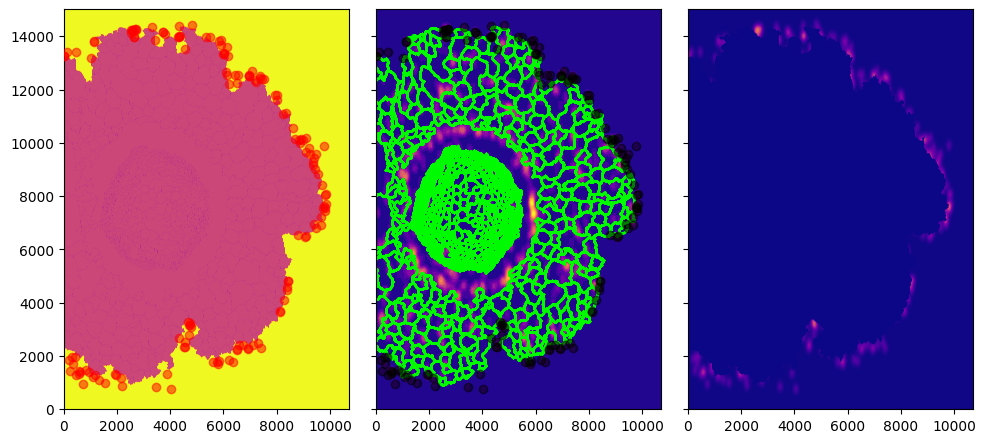

In [18]:
fig, ax = plt.subplots(1,3,figsize=(10,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(cell, cmap='plasma', origin='lower', extent=extent)
ax[0].scatter(ccoords[0], ccoords[1], c='red', marker='o', zorder=3, alpha=0.5);

ax[1].contourf(cxs, cys, cisj, 16, cmap='plasma', vmin=0, zorder=1)
ax[1].scatter(wcellcoords[1], wcellcoords[0], c='lime', marker='.', s=0.1)
ax[1].scatter(ccoords[0], ccoords[1], c='cyan', marker='o', zorder=3, alpha=0.5);

ax[2].imshow(dig, origin='lower', cmap='plasma', extent=extent, vmax=255)
#ax[2].scatter(wcellcoords[1], wcellcoords[0], c='lime', marker='.', s=0.001)

step = int(np.ediff1d(ax[0].get_xticks())[0])
for i in range(len(ax)):
    #ax[i].set_xticks(np.arange(0, cell.shape[1], step), np.arange(ss[1].start, ss[1].stop, step))
    #ax[i].set_yticks(np.arange(0, cell.shape[0], step), np.arange(ss[0].start, ss[0].stop, step))
    ax[i].set_aspect('equal')
    ax[i].margins(0)

fig.tight_layout();

In [19]:
dst = '../proc/'

sdst = dst + sample + '/'
if not os.path.isdir(sdst):
    os.mkdir(sdst)

tdst = sdst + transcriptomes[tidx] + '/'
if not os.path.isdir(tdst):
    os.mkdir(tdst)

filename = tdst + transcriptomes[tidx] + '_-_{:05d}.tif'.format(cidx)
print(filename)
tf.imwrite(filename, dig, photometric='minisblack')

../proc/B1/GLYMA_17G185800/GLYMA_17G185800_-_00000.tif
